In [21]:
%matplotlib widget
%matplotlib widget
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import IPython.display as Ipd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

synth_name = 'sin'
lookup_table_path = f'./00_synths/{synth_name}/features/lookup_table.csv'
synth_df = pd.read_csv(lookup_table_path)
param_names = [col for col in synth_df.columns if col.split('-')[0] == 'param']
loudness_feature_names = [col for col in synth_df.columns if col.split('-')[0] == 'loudness']
mfcc_feature_names = [col for col in synth_df.columns if col.split('-')[0] == 'mfcc']
chroma_feature_names = [col for col in synth_df.columns if col.split('-')[0] == 'chroma']
specshape_feature_names = [col for col in synth_df.columns if col.split('-')[0] == 'specshape']
sinefeaturefreqs_feature_names = [col for col in synth_df.columns if col.split('-')[0] == 'sinefeaturefreqs']
sinefeaturemags_feature_names = [col for col in synth_df.columns if col.split('-')[0] == 'sinefeaturemags']
feature_names = loudness_feature_names + mfcc_feature_names + chroma_feature_names + specshape_feature_names + sinefeaturefreqs_feature_names + sinefeaturemags_feature_names
synth_params = synth_df[param_names].values

synth_df = synth_df.set_index(param_names)
synth_df.describe()

,loudness-dBFS,loudness-TP,loudness-dB,mfcc-0,mfcc-1,mfcc-2,mfcc-3,mfcc-4,mfcc-5,mfcc-6,...,sinefeaturemags-0,sinefeaturemags-1,sinefeaturemags-2,sinefeaturemags-3,sinefeaturemags-4,sinefeaturemags-5,sinefeaturemags-6,sinefeaturemags-7,sinefeaturemags-8,sinefeaturemags-9
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,...,400.000000,400.000000,400.000000,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,400.000000
mean,-17.815629,-21.823062,0.346331,-335.740348,52.577734,9.578782,-38.801266,-17.087692,3.771377,4.609691,...,0.380695,0.066393,0.002114,1.426851e-04,1.638262e-05,3.919594e-06,3.869702e-06,3.827243e-06,0.000004,0.000004
std,30.137908,61.598624,0.219735,345.913956,40.269230,56.882852,46.694622,35.730713,38.237454,28.362675,...,0.237146,0.111723,0.008437,1.320333e-03,2.476347e-04,2.651840e-06,2.647146e-06,2.641277e-06,0.000003,0.000003
min,-145.710824,-288.643391,0.016340,-1837.016798,-22.952458,-83.133723,-95.257778,-69.573585,-64.735215,-54.922341,...,0.021896,0.000003,0.000001,1.817973e-07,1.787887e-07,9.927419e-08,1.001194e-07,9.056183e-08,0.000000,0.000000
25%,-16.437643,-12.142913,0.151335,-277.592264,14.367807,-37.698067,-77.452374,-51.565534,-23.420119,-15.740406,...,0.188286,0.001903,0.000005,2.054609e-06,1.868725e-06,1.747860e-06,1.703549e-06,1.653277e-06,0.000002,0.000002
50%,-9.652199,-6.346698,0.331187,-255.007299,59.845674,5.775990,-57.507757,-16.756007,8.113669,9.175542,...,0.358664,0.003223,0.000010,3.740185e-06,3.386019e-06,3.300812e-06,3.222978e-06,3.177992e-06,0.000003,0.000003
75%,-5.901087,-2.950919,0.518632,-236.793827,86.823203,62.459939,0.538851,17.611341,44.463106,28.235182,...,0.532091,0.108607,0.000034,6.036138e-06,5.798591e-06,5.721956e-06,5.687176e-06,5.672128e-06,0.000006,0.000005
max,-1.629277,-0.346129,0.870213,-210.036510,125.216184,102.405061,54.109982,40.562212,55.010433,46.169502,...,0.917371,0.425716,0.079349,1.569364e-02,4.956412e-03,1.132824e-05,1.128142e-05,1.126678e-05,0.000011,0.000011


In [27]:
#features_keep = ['loudness-0', 'specshape-centroid']
features_keep = feature_names
X = synth_df[features_keep].values
scaler = StandardScaler().fit(X)
X_normalized = scaler.transform(X)

In [28]:
pca = PCA(n_components=2).fit(X)
X_PCA = pca.transform(X)

In [29]:
tsne = TSNE(n_components=2, random_state=0)
X_TSNE = tsne.fit_transform(X_normalized) 

In [30]:
from pythonosc import udp_client

port_snd = 6667 # send port to PD
ip = "127.0.0.1" # localhost
client = udp_client.SimpleUDPClient(ip, port_snd)

def sendControlsToPD(paramsArray, client):
	paramsArray = [str(n) for n in paramsArray]
	msg = ' '.join(paramsArray)
	client.send_message("/params", msg)

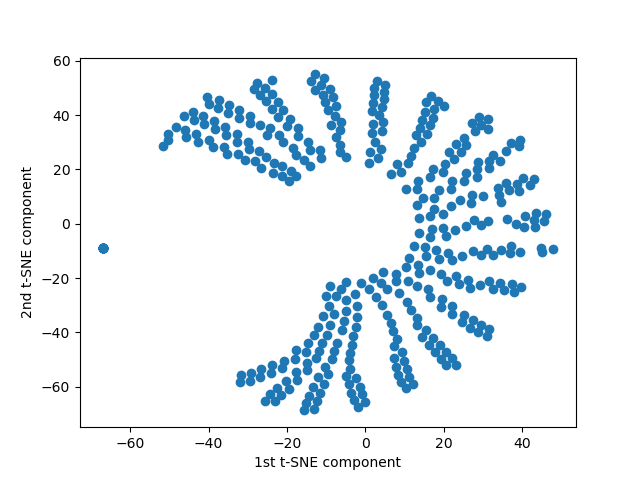

In [31]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(X_TSNE[:,0], X_TSNE[:,1])
ax.set_xlabel('1st t-SNE component')
ax.set_ylabel('2nd t-SNE component')
text = ax.text(0,0, "", va="bottom", ha="left")

# find a way to get to the closest parameter based on position
def onclick(event):
    newpoint = np.array((event.xdata, event.ydata))
    distances= np.linalg.norm(X_TSNE - newpoint, axis = 1)
    min_index = np.argmin(distances)
    tx = f'min_index = {synth_params[min_index]}'
    text.set_text(tx)
    sendControlsToPD(synth_params[min_index], client)

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()